# Задание 1. Bootstrap

В этом задании используйте датасет breast_cancer — классический датасет для задачи бинарной классификации. Обучите модели:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`.

Параметры моделей можете оставить по умолчанию или задать сами.

Для каждой модели посчитайте [корреляцию Мэтьюса](https://en.wikipedia.org/wiki/Phi_coefficient) — метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, ([`sklearn.metrics.matthews_corrcoef`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), подробнее почитать про его пользу можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) — для предсказанного ею класса и реального.

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей. Используйте функцию `bootstrap_metric()` из лекции.

Постройте [боксплоты](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей.

Импорт необходимых библиотек:

In [ ]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import average_precision_score  # PR-AUC

Загрузка датасета:

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [ ]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [ ]:
def train_and_test_regressor(models, x_train, y_train, x_test, y_test, verb=True):
    boot_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train)  # train the model
        y_pred = model.predict(x_test)  # get predictions
        boot_scores[name] = bootstrap_metric(  # calculate bootstrap score
            y_test,
            y_pred,
            metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y),
        )
        if verb:
            print(f"Fitted {name} with bootstrap score {boot_scores[name].mean():.3f}")

    results = pd.DataFrame(boot_scores)
    # cast to long format https://pandas.pydata.org/docs/reference/api/pandas.melt.html
    results = results.melt(
        value_vars=results.columns, value_name="mse", var_name="model"
    )
    return results

In [ ]:
# Your code here
clf1 = DecisionTreeClassifier(max_depth=10, random_state=42)
clf1.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [ ]:
lgbm = lightgbm.LGBMClassifier(
    n_estimators=2000,  # can use more estimators due to SPEEEEEED
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=2**5,
    random_state=42,
    min_child_weight=9,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
)
lgbm.fit(x_train, y_train)

LGBMClassifier(force_col_wise=True, min_child_weight=9, n_estimators=2000,
               n_jobs=-1, num_leaves=32, random_state=42, verbose=-1)

In [ ]:
from sklearn import svm

svmsvc = svm.SVC(kernel="rbf", C=1000)
svmsvc.fit(x_train, y_train)

SVC(C=1000)

In [ ]:
BC = BaggingClassifier(estimator=SVC(), n_estimators=100, random_state=42)
BC.fit(x_train, y_train)

BaggingClassifier(estimator=SVC(), n_estimators=100, random_state=42)

In [ ]:
y_pred1 = clf1.predict(x_test)  # by default, SVM gives score to each object instead of probabilities
y_pred2 = rf.predict(x_test)
y_pred3 = lgbm.predict(x_test)
y_pred4 = svmsvc.predict(x_test)
y_pred5 = BC.predict(x_test)

In [ ]:
y_pred1

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1])

In [ ]:
boot_score_dectree = bootstrap_metric(
    y_test, y_pred1, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
boot_score_rf = bootstrap_metric(
    y_test, y_pred2, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
boot_score_lgbm = bootstrap_metric(
    y_test, y_pred3, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
boot_score_svmsvc = bootstrap_metric(
    y_test, y_pred4, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
boot_score_BC = bootstrap_metric(
    y_test, y_pred5, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
)
alpha = 0.10
print(
    "DecisionTree 90%-ci: ",
    np.quantile(boot_score_dectree, q=[alpha / 2, 1 - alpha / 2]),
)
print("RandomForest 90%-ci:", np.quantile(boot_score_rf, q=[alpha / 2, 1 - alpha / 2]))
print(
    "LGBM 90%-ci:",
    np.quantile(boot_score_lgbm, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "SVC 90%-ci:",
    np.quantile(boot_score_svmsvc, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "BC 90%-ci:",
    np.quantile(boot_score_BC, q=[alpha / 2, 1 - alpha / 2]),
)

DecisionTree 90%-ci:  [0.82974532 0.95585337]
RandomForest 90%-ci: [0.88953352 0.98517822]
LGBM 90%-ci: [0.86988547 0.97114609]
SVC 90%-ci: [0.86911805 0.97128514]
BC 90%-ci: [0.83030554 0.95532067]


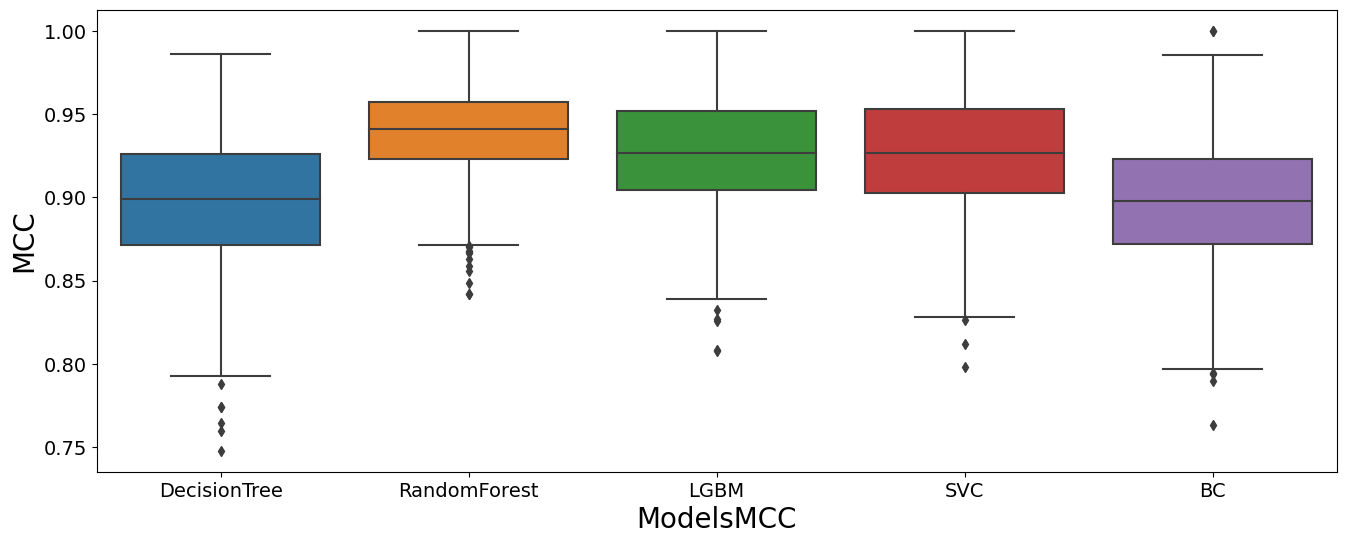

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(
    y=np.concatenate([boot_score_dectree, boot_score_rf, boot_score_lgbm, boot_score_svmsvc, boot_score_BC]),
    x=["DecisionTree"] * 1000 + ["RandomForest"] * 1000 + ["LGBM"] * 1000 + ["SVC"] * 1000 + ["BC"] * 1000,
)
plt.ylabel("MCC", size=20)
plt.xlabel("ModelsMCC", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Сделайте вывод о том, какие модели работают лучше.

**Напишите вывод**

**Лучший результат показала модель RandomForestClassifier (90% доверительный интервал [0.88953352 - 0.98517822]). Немного хуже модели LigthGBMClassifier ([0.86988547 - 0.97114609]) и SVC ([0.86911805 - 0.97128514]).**

## Формат результата

График с демонстрацией корреляции Мэтьюса для следующих моделей:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX03/result_1_task_ex03.png" width="600">

# Задание 2. Дисбаланс классов

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -qU imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_validate,
)

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [ ]:
real_labels = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, а 5 — к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [ ]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [ ]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy (см. лекцию 1) для этих моделей:

In [ ]:
print("Accuracy for model1: ", accuracy_score(real_labels, model1_res))
print("Accuracy for model2: ", accuracy_score(real_labels, model2_res))

Accuracy for model1:  0.7619047619047619
Accuracy for model2:  0.7619047619047619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [ ]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print(
    "Balanced accuracy for model1: ", balanced_accuracy_score(real_labels, model1_res)
)
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print(
    "Balanced accuracy for model2: ", balanced_accuracy_score(real_labels, model2_res)
)

Balanced accuracy for model1:  0.5
Balanced accuracy for model2:  0.775


**Всегда проверяйте**, являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли), и 0, если не ответил. Количество пациентов, отвечающих на терапию, сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров — актуальная задача в онкологии. В данном задании вам предстоит попробовать её решить.

In [ ]:
# посчитать метрики (по 2), сравнить

In [ ]:
cancer = pd.read_table(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Cancer_dataset_2.tsv",
    index_col="sample_id",
)
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer["Response"]
x = cancer.drop("Response", axis=1)
print("\nNumber of patients responded to immunotherapy:")
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


0    228
1     37
Name: Response, dtype: int64

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ &mdash; это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ &mdash; это использование специальных алгоритмов, учитывающих несбалансированность классов.


В данном задании вам нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого вы будете использовать три модели, представленные ниже:

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn — меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn — сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Оцените эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, используйте значения `accuracy` и `balanced_accuracy`. Проинтерпретируйте результаты.

In [ ]:
?imblearn.ensemble.BalancedRandomForestClassifier

In [ ]:
?cross_validate

Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы cross_validate нужно перемешать данные. Для этого используйте флаг `shuffle=True`, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции cross_validate).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rfc = RandomForestClassifier(n_estimators=1000)
rfc2 = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rfc3 = BalancedRandomForestClassifier(n_estimators=1000, class_weight='balanced')

In [ ]:
print('RandomForestClassifier:')

accuracy = cross_val_score(rfc, x_train, y_train, cv=kf, scoring="accuracy")
print(f'Среднее значение accuracy: {accuracy.mean():.4f}')
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=kf, scoring="balanced_accuracy")
print(f'Среднее значение balanced_accuracy: {balanced_accuracy.mean():.4f}')

accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring="accuracy")
print(f'Среднее значение accuracy (StratifiedKFold): {accuracy.mean():.4f}')
balanced_accuracy = cross_val_score(rfc, x_train, y_train, cv=cv, scoring="balanced_accuracy")
print(f'Среднее значение balanced_accuracy (StratifiedKFold): {balanced_accuracy.mean():.4f}')

RandomForestClassifier:
Среднее значение accuracy: 0.8440
Среднее значение balanced_accuracy: 0.5251
Среднее значение accuracy (StratifiedKFold): 0.8488
Среднее значение balanced_accuracy (StratifiedKFold): 0.5480


In [ ]:
print('RandomForestClassifier с балансировкой классов:')

accuracy = cross_val_score(rfc2, x_train, y_train, cv=kf, scoring="accuracy")
print(f'Среднее значение accuracy: {accuracy.mean():.4f}')
balanced_accuracy = cross_val_score(rfc2, x_train, y_train, cv=kf, scoring="balanced_accuracy")
print(f'Среднее значение balanced_accuracy: {balanced_accuracy.mean():.4f}')

accuracy = cross_val_score(rfc2, x_train, y_train, cv=cv, scoring="accuracy")
print(f'Среднее значение accuracy (StratifiedKFold): {accuracy.mean():.4f}')
balanced_accuracy = cross_val_score(rfc2, x_train, y_train, cv=cv, scoring="balanced_accuracy")
print(f'Среднее значение balanced_accuracy (StratifiedKFold): {balanced_accuracy.mean():.4f}')

RandomForestClassifier с балансировкой классов:
Среднее значение accuracy: 0.8487
Среднее значение balanced_accuracy: 0.5292
Среднее значение accuracy (StratifiedKFold): 0.8488
Среднее значение balanced_accuracy (StratifiedKFold): 0.5623


In [ ]:
from IPython.display import clear_output

accuracy = cross_val_score(rfc3, x_train, y_train, cv=kf, scoring="accuracy")

balanced_accuracy = cross_val_score(rfc3, x_train, y_train, cv=kf, scoring="balanced_accuracy")


accuracy1 = cross_val_score(rfc3, x_train, y_train, cv=cv, scoring="accuracy")

balanced_accuracy1 = cross_val_score(rfc3, x_train, y_train, cv=cv, scoring="balanced_accuracy")
clear_output(wait=True)
print('BalancedRandomForestClassifier:')
print(f'Среднее значение accuracy: {accuracy.mean():.4f}')
print(f'Среднее значение balanced_accuracy: {balanced_accuracy.mean():.4f}')
print(f'Среднее значение accuracy (StratifiedKFold): {accuracy1.mean():.4f}')
print(f'Среднее значение balanced_accuracy (StratifiedKFold): {balanced_accuracy1.mean():.4f}')

BalancedRandomForestClassifier:
Среднее значение accuracy: 0.6749
Среднее значение balanced_accuracy: 0.6416
Среднее значение accuracy (StratifiedKFold): 0.7117
Среднее значение balanced_accuracy (StratifiedKFold): 0.6730


In [ ]:
# Your code here

Какая модель лучше справляется с дисбалансом классов?

**Напишите вывод**

**Лучше справляется с дисбалансом классов модель BalancedRandomForestClassifier, т. к. по абсолютным значениям лучшее значение balanced_accuracy, и меньшая разница между accuracy и balanced_accuracy.**

## Формат результата

Получить значения `accuracy` и `balanced_accuracy`для моделей:
1. `RandomForestClassifier`, библиотека sklearn;
2. `RandomForestClassifier с балансировкой классов`, библиотека sklearn;
3. `BalancedRandomForestClassifier`, библиотека imblearn.


# Задание 3. Разные типы бустингов

В этом задании будем использовать датасет с рейтингом блюд по некоторым характеристикам.

В некоторых реализациях градиентного бустинга есть возможность использовать другой метод обучения. Например, в XGB есть тип `dart`, а в lgbm — `goss`. Это позволяет составлять более эффективные ансамбли.

Используя кросс-валидацию (используйте 3 фолда), обучите модели:
* CatboostRegressor
* XGBRegressor
* LGBMRegressor

Сохраните модель на каждом фолде и посчитайте `mse` для тестовой выборки, используя модель с каждого фолда. Получите предсказания всех 9 моделей на тестовой выборке и усредните их. Затем посчитайте `mse` для усредненных предсказаний.

Напишите выводы о полученном качестве моделей.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00


In [ ]:
import xgboost
import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)
recipies

,calories,protein,fat,sodium,cakeweek,wasteless,rating
0,426.0,30.0,7.0,559.0,0.0,0.0,2.500
1,403.0,18.0,23.0,1439.0,0.0,0.0,4.375
2,165.0,6.0,7.0,165.0,0.0,0.0,3.750
3,547.0,20.0,32.0,452.0,0.0,0.0,3.125
4,948.0,19.0,79.0,1042.0,0.0,0.0,4.375
...,...,...,...,...,...,...,...
15859,28.0,2.0,2.0,64.0,0.0,0.0,3.125
15860,671.0,22.0,28.0,583.0,0.0,0.0,4.375
15861,563.0,31.0,38.0,652.0,0.0,0.0,4.375
15862,631.0,45.0,24.0,517.0,0.0,0.0,4.375


In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train_all, x_test, y_train_all, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
KF = KFold(n_splits=3, random_state=42, shuffle=True)
catbust = catboost.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,
    random_state=42,
    verbose=0,
)
xgb = xgboost.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        booster='dart',
        rate_drop=0.9,
        one_drop=True,
        min_child_weight=9,
        n_jobs=-1,
        objective="reg:squarederror",
    )
lgbm = lightgbm.LGBMRegressor(
    n_estimators=2000,  # can use more estimators due to SPEEEEEED
    learning_rate=0.1,
    boosting_type='goss',
    max_depth=-1,
    num_leaves=2**5,
    random_state=42,
    min_child_weight=9,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
)

In [ ]:
# Your code here
catb = []
XGB = []
LGBM = []
for train_index, test_index in KF.split(x_train_all):

    catbust.fit(x_train_all[train_index], y_train_all[train_index])
    y_pred1 = catbust.predict(x_test)
    catb.append(y_pred1)

In [ ]:
for train_index, test_index in KF.split(x_train_all):
    xgb.fit(x_train_all[train_index], y_train_all[train_index])
    y_pred2 = xgb.predict(x_test)
    XGB.append(y_pred2)

In [ ]:
for train_index, test_index in KF.split(x_train_all):
    lgbm.fit(x_train_all[train_index], y_train_all[train_index])
    y_pred3 = lgbm.predict(x_test)
    LGBM.append(y_pred3)

In [ ]:
print(catb)
print(XGB)
print(LGBM)

[array([3.45359658, 3.59534489, 4.27339216, ..., 4.40282217, 3.98442568,
       3.6495745 ]), array([4.00997042, 3.52238725, 4.40529756, ..., 3.51622673, 4.00373055,
       4.05327931]), array([3.51388788, 4.12715075, 4.50474609, ..., 4.45147526, 4.08018829,
       3.87424259])]
[array([3.827027 , 3.8942606, 3.9012506, ..., 3.8282661, 3.8942606,
       3.901586 ], dtype=float32), array([3.8456354, 3.8300474, 3.8803992, ..., 3.8456354, 3.8456354,
       3.9207656], dtype=float32), array([3.8033993, 3.8886368, 3.9393837, ..., 3.8886368, 3.8886368,
       3.9393837], dtype=float32)]
[array([3.90857419, 2.89624268, 4.21466802, ..., 4.17509831, 4.47145473,
       2.76800338]), array([4.47653612, 3.11560459, 4.03446142, ..., 3.07399817, 4.01614443,
       3.81263169]), array([4.33369216, 3.75900155, 3.51109325, ..., 4.36659162, 4.31306637,
       3.96676008])]


In [ ]:
catb[1]

array([4.00997042, 3.52238725, 4.40529756, ..., 3.51622673, 4.00373055,
       4.05327931])

In [ ]:
print('CatboostRegressor:')
mse_1 = mean_squared_error(y_test, catb[0])
mse_2 = mean_squared_error(y_test, catb[1])
mse_3 = mean_squared_error(y_test, catb[2])

print(f'Fold №1, mse: {mse_1}')
print(f'Fold №2, mse: {mse_2}')
print(f'Fold №3, mse: {mse_3}')
print(f'Средняя mse: {(mse_1 + mse_2 + mse_3)/3}')

CatboostRegressor:
Fold №1, mse: 1.6244117002310903
Fold №2, mse: 1.648539342282453
Fold №3, mse: 1.6128920640123396
Средняя mse: 1.628614368841961


In [ ]:
print('XGBRegressor:')
mse_4 = mean_squared_error(y_test, XGB[0])
mse_5 = mean_squared_error(y_test, XGB[1])
mse_6 = mean_squared_error(y_test, XGB[2])

print(f'Fold №1, mse: {mse_4}')
print(f'Fold №2, mse: {mse_5}')
print(f'Fold №3, mse: {mse_6}')
print(f'Средняя mse: {(mse_4 + mse_5 + mse_6)/3}')

XGBRegressor:
Fold №1, mse: 1.5714850799813957
Fold №2, mse: 1.557110526816755
Fold №3, mse: 1.547445703483992
Средняя mse: 1.5586804367607143


In [ ]:
print('LGBMRegressor:')
mse_7 = mean_squared_error(y_test, LGBM[0])
mse_8 = mean_squared_error(y_test, LGBM[1])
mse_9 = mean_squared_error(y_test, LGBM[2])

print(f'Fold №1, mse: {mse_7}')
print(f'Fold №2, mse: {mse_8}')
print(f'Fold №3, mse: {mse_9}')
print(f'Средняя mse: {(mse_7 + mse_8 + mse_9)/3}')

LGBMRegressor:
Fold №1, mse: 1.989210096321297
Fold №2, mse: 1.9606397461110983
Fold №3, mse: 1.9421490455380808
Средняя mse: 1.963999629323492


## Формат результата

Получить значения MSE для всех моделей и значение MSE, усреднив предсказания всех моделей. Написать вывод.


**Вывод. Наименьшее значение MSE получилось при использовании XGBoost с типом 'dart'. Что интересно, оно меньше того, что получалось при использовании дефолтного типа (MSE 1.559 против 1.814). CatBoost и LGBM дали результаты похуже (MSE 1.629 и 1.964). LGBM дал результат лучше при использовании стандартного типа (MSE 1.886).**

# Задание 4. Подбор гиперпараметров

В этом задании нужно подобрать параметры для бустинга `CatBoostRegressor`, используя библиотеку `optuna`. И улучшить результат по сравнению со стандартными параметрами.

Список параметров для подбора:

* `depth`
* `iterations`
* `learning_rate`
* `colsample_bylevel`
* `subsample`
* `l2_leaf_reg`
* `min_data_in_leaf`
* `max_bin`
* `random_strength`
* `bootstrap_type`

**Важно!** *Подбирать параметры нужно на валидационной выборке*

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q optuna

In [ ]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from optuna.samplers import RandomSampler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)

In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
model = CatBoostRegressor(random_seed=42)

model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

print("\nmse_score before tuning: ", mse(y_test, model.predict(x_test)))

Learning rate set to 0.074308
0:	learn: 1.2817437	test: 1.2774827	best: 1.2774827 (0)	total: 4.24ms	remaining: 4.24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.242760353
bestIteration = 44

Shrink model to first 45 iterations.

mse_score before tuning:  1.5444532948674852


In [ ]:
# Your code here

In [ ]:
import optuna
from optuna.samplers import RandomSampler

# Define function which will optimized

def objective(trial):
    # boundaries for the optimizer's
    depth = trial.suggest_int("depth", 5, 9, step=1)
    iterations = trial.suggest_int("iterations", 100, 2000, step=1)
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.3, step=0.05)
    colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.3, 0.8, step=0.1)
    subsample = trial.suggest_float("subsample", 0.1, 0.5, step=0.1)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 6, 14, step=2)
    l2_leaf_reg = trial.suggest_categorical("l2_leaf_reg", [2, 5, 7, 10])
    random_strength = trial.suggest_float("random_strength", 1, 4, step=1)
    max_bin = trial.suggest_int("max_bin", 128, 4096, step=128)
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ['Bernoulli', 'MVS'])

    # create new model(and all parameters) every iteration
    model = catboost.CatBoostRegressor(
        depth=depth,
        iterations=iterations,
        learning_rate=learning_rate,
        colsample_bylevel=colsample_bylevel,
        subsample=subsample,
        min_data_in_leaf=min_data_in_leaf,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        max_bin=max_bin,
        bootstrap_type=bootstrap_type,
        random_state=42,
        verbose=0,
    )

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    boot_score = bootstrap_metric(
        y_test,
        y_pred,
        metric_fn=lambda x, y: mean_squared_error(y_true=x, y_pred=y),
    )

    return boot_score.mean()


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=RandomSampler(42)
)

study.optimize(
    objective, n_trials=20
)  # The more iterations, the higher the chances of catching the most optimal hyperparameters

[I 2023-10-26 19:59:01,913] A new study created in memory with name: Optimizer
[I 2023-10-26 19:59:12,502] Trial 0 finished with value: 1.6012539269466497 and parameters: {'depth': 6, 'iterations': 1907, 'learning_rate': 0.25, 'colsample_bylevel': 0.6000000000000001, 'subsample': 0.1, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5, 'random_strength': 1.0, 'max_bin': 4096, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 1.6012539269466497.
[I 2023-10-26 19:59:15,749] Trial 1 finished with value: 1.5478782875942771 and parameters: {'depth': 5, 'iterations': 448, 'learning_rate': 0.1, 'colsample_bylevel': 0.6000000000000001, 'subsample': 0.30000000000000004, 'min_data_in_leaf': 8, 'l2_leaf_reg': 2, 'random_strength': 2.0, 'max_bin': 3328, 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 1.5478782875942771.
[I 2023-10-26 19:59:17,056] Trial 2 finished with value: 1.545669155596906 and parameters: {'depth': 7, 'iterations': 188, 'learning_rate': 0.2, 'colsample_bylevel': 0.4, 'sub

In [ ]:
print(study.best_params)

{'depth': 8, 'iterations': 477, 'learning_rate': 0.05, 'colsample_bylevel': 0.7, 'subsample': 0.4, 'min_data_in_leaf': 12, 'l2_leaf_reg': 2, 'random_strength': 4.0, 'max_bin': 2560, 'bootstrap_type': 'Bernoulli'}


## Формат результата

Значение `mse` с подобранными параметрами меньше, чем при стандартных параметрах.

**Получили значение MSE 1.527479227126284, а при стандартных параметрах 1.5444532948674852**

# Задание 5. Ансамблевое обучение (Дополнительно)

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci).

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q lightgbm==3.0

In [ ]:
import catboost
import lightgbm
import xgboost
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)

Загрузка датасета:

In [ ]:
heart_dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/heart.csv "
)

In [ ]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
rng = np.random.RandomState(42)

dt = DecisionTreeClassifier(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
etc = ExtraTreesClassifier(random_state=rng)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
svc_lin = SVC(kernel='linear', probability=True, random_state=rng)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=rng)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=42)
lgbm = lightgbm.LGBMClassifier(random_state=42)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", subsample_freq=1,subsample=0.7, random_state=42)
xgb = xgboost.XGBClassifier(random_state=42)
xgb_rf = xgboost.XGBRFClassifier(random_state=42)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

# Your code here
voting_hard = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('xgb', xgb)], voting='hard')
voting_soft = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('xgb', xgb)], voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf,  xgb, lgbm,  xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
   scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
   print(f'{model.__class__.__name__}: {scores.mean()}')


DecisionTreeClassifier: 0.7957693229810229
RandomForestClassifier: 0.7775258199977301
CatBoostClassifier: 0.8383007326745985
ExtraTreesClassifier: 0.8322016736650882
KNeighborsClassifier: 0.6182226182226181
SVC: 0.8386009216039275
SVC: 0.7014610456939684
XGBClassifier: 0.8568650829840246
[LightGBM] [Info] Number of positive: 83, number of negative: 68
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549669 -> initscore=0.199333
[LightGBM] [Info] Start training from score 0.199333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них, не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тренировочном наборе и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Можете модифицировать функцию `base_model_pair_correlation` из лекции.

In [ ]:
import scipy# Your code here
df = []
models_list = [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]
for model in models_list:
    df_temp = []
    model.fit(x_train, y_train)
    for model1 in models_list:
        model1.fit(x_train, y_train)
        df_1 = (model.predict_proba(x_test.values))
        df_2 = (model1.predict_proba(x_test.values))
        df_temp.append(np.round(scipy.stats.pearsonr(df_1.flatten(), df_2.flatten())[0],2))
    df.append(df_temp)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have v

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X doe

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not ha

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does no

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not ha

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted wi

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid fe

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have val

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid fea

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature

[LightGBM] [Info] Number of positive: 124, number of negative: 103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546256 -> initscore=0.185553
[LightGBM] [Info] Start training from score 0.185553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [ ]:
models_list_labels = ('dt', 'rf', 'knn', 'etc', 'svc_lin', 'svc_rbf', 'cat', 'lgbm', 'lgbm_rf', 'xgb', 'xgb_rf', 'lr', 'nb')
df = np.array(df)

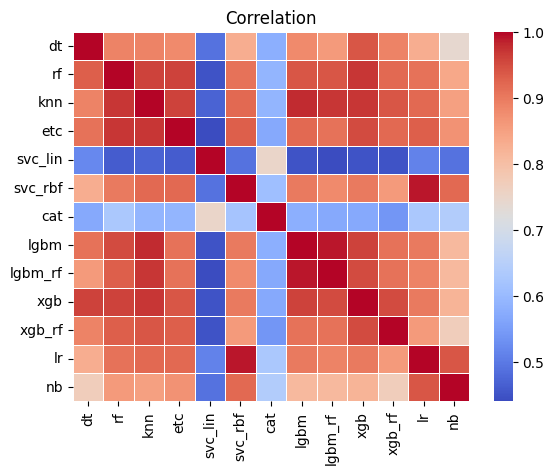

In [ ]:
import seaborn as sns
ax = sns.heatmap(df, linewidth=0.5 , cmap='coolwarm', xticklabels=models_list_labels, yticklabels=models_list_labels)

plt.title("Correlation")
plt.show()

Создайте новый ансамбль, на исправленном наборе моделей и оцените его качество с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
# Your code here

voting_hard_2 = VotingClassifier(estimators=[('cat', cat), ('svc_lin', svc_lin), ('svc_rbf', svc_rbf), ('nb', nb)], voting='hard')
voting_soft_2 = VotingClassifier(estimators=[('cat', cat), ('svc_lin', svc_lin), ('svc_rbf', svc_rbf), ('nb', nb)], voting='soft')
# ------------

for model in [voting_hard_2, voting_soft_2]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

VotingClassifier: 0.8237155232190508
VotingClassifier: 0.8446774353947349


In [ ]:
# Your code here

voting_hard_3 = VotingClassifier(estimators=[('cat', cat), ('svc_lin', svc_lin), ('svc_rbf', svc_rbf), ('nb', nb), ('rf', rf), ('dt', dt), ('etc', etc)], voting='hard')
voting_soft_3 = VotingClassifier(estimators=[('cat', cat), ('svc_lin', svc_lin), ('svc_rbf', svc_rbf), ('nb', nb), ('rf', rf), ('dt', dt), ('etc', etc)], voting='soft')
# ------------

for model in [voting_hard_3, voting_soft_3]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

VotingClassifier: 0.8440579710144928
VotingClassifier: 0.8378187979311575


Обучите все получившиеся модели на тренировочном наборе и испытайте их качество на тестовом наборе. Получилось ли у улучшенных версий ансамблевого классификатора превзойти базовые модели, входящие в него, и свои предыдущие версии?

In [ ]:
# Your code here

In [ ]:
voting_hard_2 = voting_hard_2.fit(x_train, y_train)
voting_soft_2 = voting_soft_2.fit(x_train, y_train)
for model in [voting_hard_2, voting_soft_2]:
  scores = accuracy_score(y_test, model.predict(x_test))
  print(f'{model.__class__.__name__}: {scores}')# Your code here

VotingClassifier: 0.868421052631579
VotingClassifier: 0.8947368421052632


In [ ]:
voting_hard_3 = voting_hard_3.fit(x_train, y_train)
voting_soft_3 = voting_soft_3.fit(x_train, y_train)
for model in [voting_hard_3, voting_soft_3]:
  scores = accuracy_score(y_test, model.predict(x_test))
  print(f'{model.__class__.__name__}: {scores}')# Your code here

VotingClassifier: 0.8421052631578947
VotingClassifier: 0.881578947368421


Какие ансамбли работают лучше? Всегда ли больше моделей значит лучше?

**Напишите вывод**

**Вывод. Лучше работают ансамбли из моделей с наименее коррелирующими классификаторами. Больше моделей не всегда лучше, т.к. есть шанс того, что число слабо коррелирующих моделей ограничено.**

## Формат результата

Получить значения качества для ансамблей и моделей.